<a href="https://colab.research.google.com/github/MehrdadJalali-AI/GraphDBSCAN/blob/main/GraphDBSCAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading dblp dataset...
Original Graph: 317080 nodes, 1049866 edges
Sampled Graph: 1000 nodes, 4288 edges


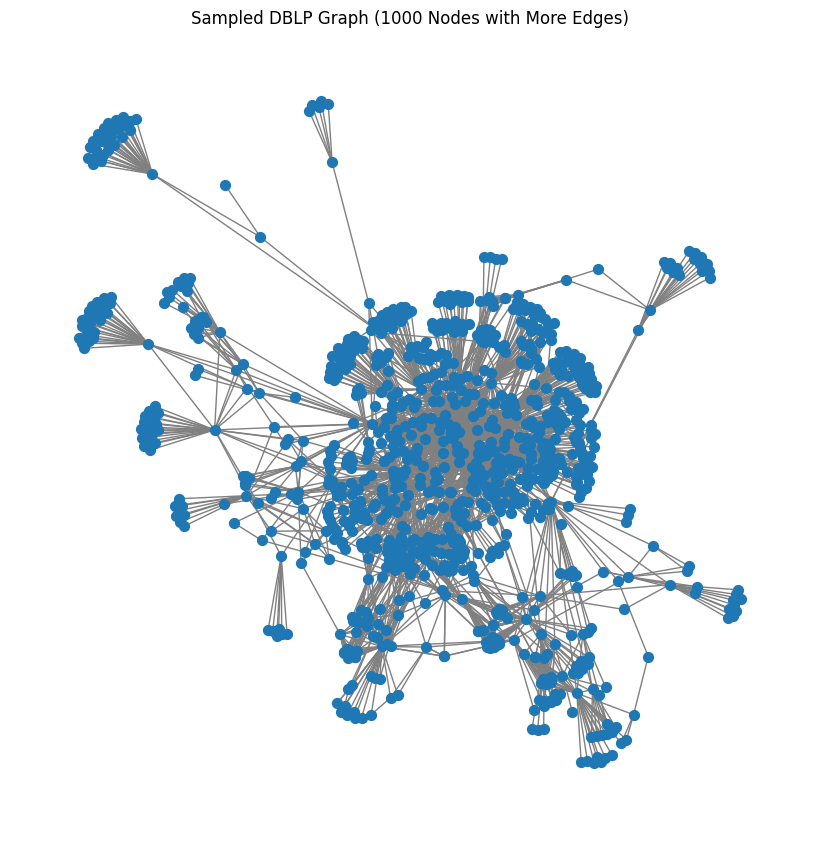


Social Network Analysis Metrics:
Density: 0.0086
Average Degree: 8.5760
Average Betweenness: 0.0028
Average Closeness: 0.2721
Detected 2 communities.
Modularity Score: 0.0208


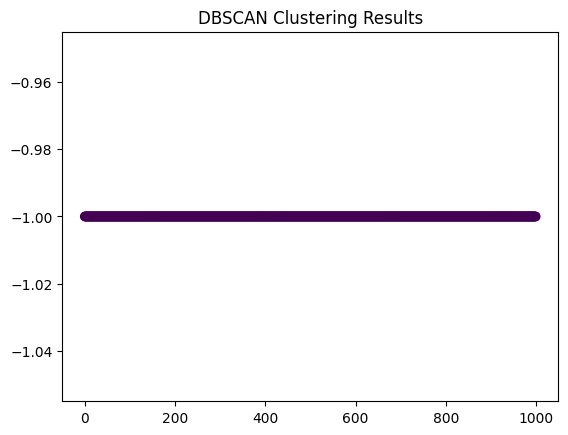

In [8]:
import math
import os
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms.community import girvan_newman, greedy_modularity_communities, modularity
from sklearn.cluster import DBSCAN
from sklearn.neighbors import KernelDensity
import random
import gzip
from urllib.request import urlretrieve
from collections import deque

# Install required dependencies in Colab
try:
    import google.colab
    !pip install networkx scikit-learn matplotlib
except ImportError:
    pass  # Not in Colab

# Function to download datasets
def download_dataset(url, filename):
    if not os.path.exists(filename):
        print(f"Downloading {filename}...")
        urlretrieve(url, filename)

# Load dataset from SNAP (YouTube, DBLP, Amazon) and sample 1000 nodes with more edges
def load_graph(dataset_name):
    dataset_urls = {
        "dblp": "https://snap.stanford.edu/data/bigdata/communities/com-dblp.ungraph.txt.gz",
        "amazon": "https://snap.stanford.edu/data/bigdata/communities/com-amazon.ungraph.txt.gz",
        "youtube": "https://snap.stanford.edu/data/bigdata/communities/com-youtube.ungraph.txt.gz",
    }

    if dataset_name not in dataset_urls:
        raise ValueError("Invalid dataset name. Choose from 'dblp', 'amazon', 'youtube'")

    dataset_path = dataset_name + ".txt.gz"

    download_dataset(dataset_urls[dataset_name], dataset_path)

    print(f"Loading {dataset_name} dataset...")
    G = nx.Graph()
    with gzip.open(dataset_path, 'rt') as f:
        for line in f:
            if line.startswith("#"):  # Skip comments
                continue
            node1, node2 = line.strip().split()
            G.add_edge(int(node1), int(node2))

    print(f"Original Graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

    # Sample 1000 nodes while keeping edges intact using BFS expansion
    seed_node = random.choice(list(G.nodes()))
    sampled_nodes = set()
    queue = deque([seed_node])
    while queue and len(sampled_nodes) < 1000:
        node = queue.popleft()
        if node not in sampled_nodes:
            sampled_nodes.add(node)
            queue.extend(G.neighbors(node))  # Expand BFS

    G_sampled = G.subgraph(sampled_nodes).copy()

    print(f"Sampled Graph: {G_sampled.number_of_nodes()} nodes, {G_sampled.number_of_edges()} edges")
    return G_sampled

# Function to plot community graph
def plot_community_graph(G, title):
    plt.figure(figsize=(8, 8))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, node_size=50, with_labels=False, edge_color='gray')
    plt.title(title)
    plt.show()

# Function for Social Network Analysis (SNA) metrics
def calculate_sna_metrics(G):
    density = nx.density(G)
    avg_degree = sum(dict(G.degree()).values()) / len(G.nodes())
    betweenness = nx.betweenness_centrality(G)
    avg_betweenness = sum(betweenness.values()) / len(G.nodes())
    closeness = nx.closeness_centrality(G)
    avg_closeness = sum(closeness.values()) / len(G.nodes())

    print("\nSocial Network Analysis Metrics:")
    print(f"Density: {density:.4f}")
    print(f"Average Degree: {avg_degree:.4f}")
    print(f"Average Betweenness: {avg_betweenness:.4f}")
    print(f"Average Closeness: {avg_closeness:.4f}")

    return density, avg_degree, avg_betweenness, avg_closeness

# Function for DBSCAN clustering
def dbscan_clustering(G, eps=0.5, min_samples=5):
    X = np.array(list(G.nodes())).reshape(-1, 1)  # Convert nodes to numerical array
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
    return clustering.labels_

# Function for Community Detection using Girvan-Newman and Modularity Calculation
def detect_communities_gn(G):
    communities = next(girvan_newman(G))
    communities = [list(c) for c in communities]
    modularity_score = nx.community.modularity(G, communities)

    print(f"Detected {len(communities)} communities.")
    print(f"Modularity Score: {modularity_score:.4f}")

    return communities, modularity_score

# Load DBLP dataset as an example
G = load_graph("dblp")
plot_community_graph(G, "Sampled DBLP Graph (1000 Nodes with More Edges)")

# Compute SNA Metrics
calculate_sna_metrics(G)

# Detect Communities and Compute Modularity
communities, modularity_score = detect_communities_gn(G)

# Run DBSCAN clustering
labels = dbscan_clustering(G, eps=0.5, min_samples=10)

# Plot results
plt.scatter(range(len(labels)), labels, c=labels, cmap='viridis')
plt.title("DBSCAN Clustering Results")
plt.show()


Loading dblp dataset...
Original Graph: 317080 nodes, 1049866 edges
Sampled Graph: 1000 nodes, 4555 edges


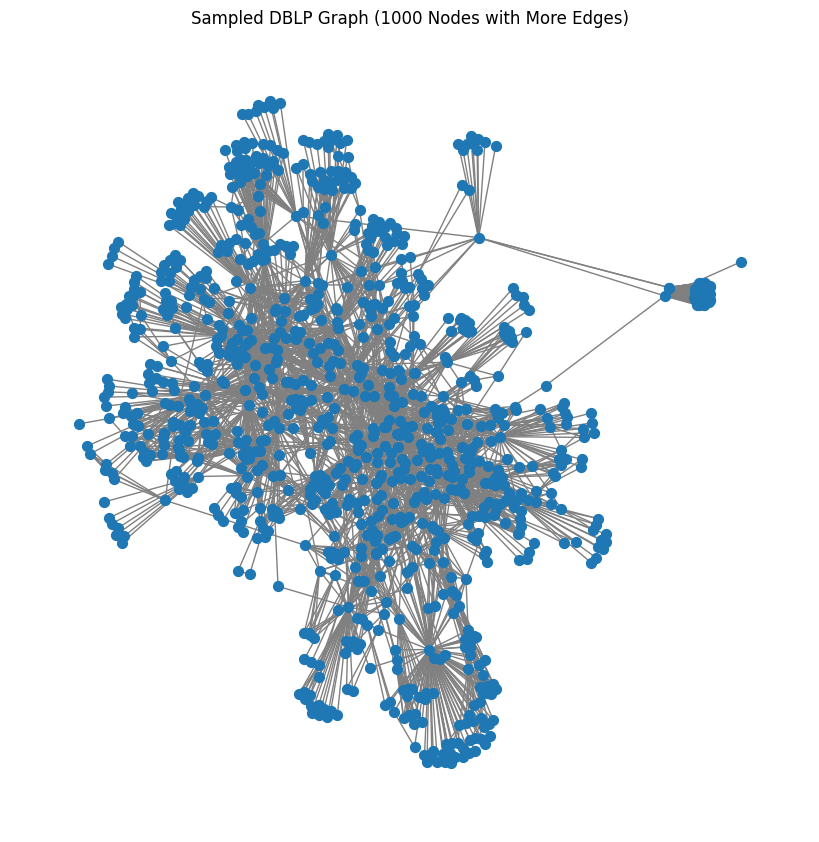

Optimal DBSCAN Parameters: eps=805.5250, min_samples=10
Removed 726 noise nodes from the graph.
Filtered Graph: 274 nodes, 465 edges
Detected 48 communities.
Modularity Score: 0.5745


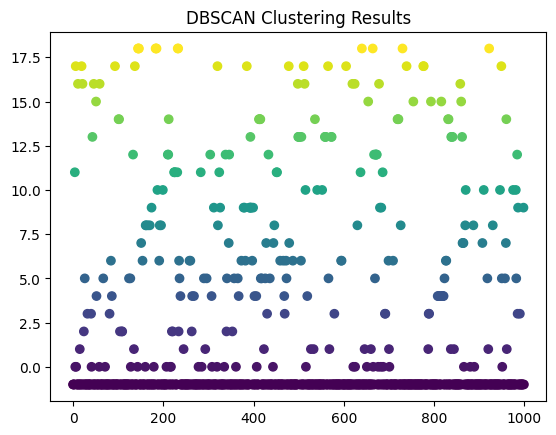

In [11]:
import math
import os
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms.community import girvan_newman, greedy_modularity_communities, modularity
from sklearn.cluster import DBSCAN
from sklearn.neighbors import KernelDensity, NearestNeighbors
import random
import gzip
from urllib.request import urlretrieve
from collections import deque

# Install required dependencies in Colab
try:
    import google.colab
    !pip install networkx scikit-learn matplotlib
except ImportError:
    pass  # Not in Colab

# Function to download datasets
def download_dataset(url, filename):
    if not os.path.exists(filename):
        print(f"Downloading {filename}...")
        urlretrieve(url, filename)

# Load dataset from SNAP (YouTube, DBLP, Amazon) and sample 1000 nodes with more edges
def load_graph(dataset_name):
    dataset_urls = {
        "dblp": "https://snap.stanford.edu/data/bigdata/communities/com-dblp.ungraph.txt.gz",
        "amazon": "https://snap.stanford.edu/data/bigdata/communities/com-amazon.ungraph.txt.gz",
        "youtube": "https://snap.stanford.edu/data/bigdata/communities/com-youtube.ungraph.txt.gz",
    }

    if dataset_name not in dataset_urls:
        raise ValueError("Invalid dataset name. Choose from 'dblp', 'amazon', 'youtube'")

    dataset_path = dataset_name + ".txt.gz"

    download_dataset(dataset_urls[dataset_name], dataset_path)

    print(f"Loading {dataset_name} dataset...")
    G = nx.Graph()
    with gzip.open(dataset_path, 'rt') as f:
        for line in f:
            if line.startswith("#"):  # Skip comments
                continue
            node1, node2 = line.strip().split()
            G.add_edge(int(node1), int(node2))

    print(f"Original Graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

    # Sample 1000 nodes while keeping edges intact using BFS expansion
    seed_node = random.choice(list(G.nodes()))
    sampled_nodes = set()
    queue = deque([seed_node])
    while queue and len(sampled_nodes) < 1000:
        node = queue.popleft()
        if node not in sampled_nodes:
            sampled_nodes.add(node)
            queue.extend(G.neighbors(node))  # Expand BFS

    G_sampled = G.subgraph(sampled_nodes).copy()

    print(f"Sampled Graph: {G_sampled.number_of_nodes()} nodes, {G_sampled.number_of_edges()} edges")
    return G_sampled

# Function to compute optimal DBSCAN parameters using KNN density estimation
def compute_optimal_dbscan_params(G):
    X = np.array(list(G.nodes())).reshape(-1, 1)
    neigh = NearestNeighbors(n_neighbors=5)
    neigh.fit(X)
    distances, _ = neigh.kneighbors(X)
    optimal_eps = np.mean(distances[:, -1])
    optimal_min_samples = max(5, int(len(G.nodes()) * 0.01))  # 1% of nodes as min_samples
    print(f"Optimal DBSCAN Parameters: eps={optimal_eps:.4f}, min_samples={optimal_min_samples}")
    return optimal_eps, optimal_min_samples

# Function for DBSCAN clustering with noise removal
def dbscan_clustering(G):
    eps, min_samples = compute_optimal_dbscan_params(G)
    X = np.array(list(G.nodes())).reshape(-1, 1)
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(X)

    # Identify noise points (nodes with label -1)
    noise_nodes = [node for node, label in zip(G.nodes(), clustering.labels_) if label == -1]

    # Create a filtered graph without noise nodes
    G_filtered = G.copy()
    G_filtered.remove_nodes_from(noise_nodes)

    print(f"Removed {len(noise_nodes)} noise nodes from the graph.")
    print(f"Filtered Graph: {G_filtered.number_of_nodes()} nodes, {G_filtered.number_of_edges()} edges")

    return clustering.labels_, G_filtered

# Function for Community Detection using Modified Girvan-Newman with Closeness-based Edge Removal
def detect_communities_gn(G):
    closeness = nx.closeness_centrality(G)
    edges = sorted(G.edges, key=lambda edge: max(closeness[edge[0]], closeness[edge[1]]), reverse=True)
    G_temp = G.copy()
    removed_edges = 0
    while nx.is_connected(G_temp) and removed_edges < len(edges) * 0.1:  # Removing top 10% highest closeness edges
        G_temp.remove_edge(*edges[removed_edges])
        removed_edges += 1

    communities = next(girvan_newman(G_temp))
    communities = [list(c) for c in communities]
    modularity_score = nx.community.modularity(G_temp, communities)

    print(f"Detected {len(communities)} communities.")
    print(f"Modularity Score: {modularity_score:.4f}")

    return communities, modularity_score

# Function to plot community graph
def plot_community_graph(G, title):
    plt.figure(figsize=(8, 8))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, node_size=50, with_labels=False, edge_color='gray')
    plt.title(title)
    plt.show()

# Load DBLP dataset as an example
G = load_graph("dblp")
plot_community_graph(G, "Sampled DBLP Graph (1000 Nodes with More Edges)")

# Compute optimal DBSCAN parameters and remove noise
labels, G_filtered = dbscan_clustering(G)

# Detect communities after noise removal using modified Girvan-Newman method
communities, modularity_score = detect_communities_gn(G_filtered)

# Plot results
plt.scatter(range(len(labels)), labels, c=labels, cmap='viridis')
plt.title("DBSCAN Clustering Results")
plt.show()


In [12]:
# Compute SNA Metrics Before Noise Removal
print("\n--- Before Noise Removal ---")
density_before, avg_degree_before, betweenness_before, closeness_before = calculate_sna_metrics(G)

# Run DBSCAN clustering and remove noise
labels, G_filtered = dbscan_clustering(G)

# Compute SNA Metrics After Noise Removal
print("\n--- After Noise Removal ---")
density_after, avg_degree_after, betweenness_after, closeness_after = calculate_sna_metrics(G_filtered)

# Compare Results
print("\n--- Comparison of Graph Metrics ---")
print(f"Nodes Before: {G.number_of_nodes()}, Nodes After: {G_filtered.number_of_nodes()}")
print(f"Edges Before: {G.number_of_edges()}, Edges After: {G_filtered.number_of_edges()}")
print(f"Density Before: {density_before:.4f}, Density After: {density_after:.4f}")
print(f"Avg Degree Before: {avg_degree_before:.4f}, Avg Degree After: {avg_degree_after:.4f}")



--- Before Noise Removal ---

Social Network Analysis Metrics:
Density: 0.0091
Average Degree: 9.1100
Average Betweenness: 0.0025
Average Closeness: 0.2863
Optimal DBSCAN Parameters: eps=805.5250, min_samples=10
Removed 726 noise nodes from the graph.
Filtered Graph: 274 nodes, 465 edges

--- After Noise Removal ---

Social Network Analysis Metrics:
Density: 0.0124
Average Degree: 3.3942
Average Betweenness: 0.0068
Average Closeness: 0.1064

--- Comparison of Graph Metrics ---
Nodes Before: 1000, Nodes After: 274
Edges Before: 4555, Edges After: 465
Density Before: 0.0091, Density After: 0.0124
Avg Degree Before: 9.1100, Avg Degree After: 3.3942
